In [ ]:
import gymnasium as gym
import numpy as np
import random
import copy
from collections import defaultdict, deque, namedtuple
from gymnasium.envs.registration import register
import minigrid
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gymnasium.envs.registration import register
from enemy_doorkey_env import DoorKeyWithEnemyEnv

register(
    id='MiniGrid-DoorKey-6x6-Enemy-v0',
    entry_point='enemy_doorkey_env:DoorKeyWithEnemyEnv',
    kwargs={'size': 6}
)

In [ ]:
import gymnasium as gym
import numpy as np
import random
import copy
from collections import defaultdict, deque, namedtuple
from gymnasium.envs.registration import register
import minigrid
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from enemy_doorkey_env import DoorKeyWithEnemyEnv

# ==================== REGISTER CUSTOM ENVIRONMENT ====================
register(
    id='MiniGrid-DoorKey-6x6-Enemy-v0',
    entry_point='enemy_doorkey_env:DoorKeyWithEnemyEnv',
    kwargs={'size': 6}
)

# ==================== CONFIGURATION ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== DUELING DQN ARCHITECTURE ====================
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        
        # Feature extraction layer - dimensiune mai mare pentru state extins
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.1),  # Pentru generalizare
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )
        
        # Value stream - V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Advantage stream - A(s,a)
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

# ==================== STATE ENCODING ====================
def get_state(env):
    """Extrage starea din environment cu coordonate relative + info inamic"""
    u = env.unwrapped
    ax, ay = u.agent_pos
    ad = int(u.agent_dir)  # 0:Right, 1:Down, 2:Left, 3:Up
    
    # Inițializează toate variabilele
    key_pos = None
    door_pos = None
    goal_pos = None
    enemy_pos = None
    door_open = 0
    
    for i in range(u.width):
        for j in range(u.height):
            obj = u.grid.get(i, j)
            if obj:
                if obj.type == "key":
                    key_pos = (i, j)
                elif obj.type == "door":
                    door_pos = (i, j)
                    door_open = 1 if obj.is_open else 0
                elif obj.type == "goal":
                    goal_pos = (i, j)
                elif obj.type == "ball" and obj.color == "red":
                    enemy_pos = (i, j)
    
    # Verifică dacă agentul are cheia
    has_key = 1 if (u.carrying and u.carrying.type == "key") else 0
    
    # Determină ținta logică (curriculum implicit)
    if not has_key and key_pos:
        target = key_pos
    elif has_key and not door_open and door_pos:
        target = door_pos
    elif door_open and goal_pos:
        target = goal_pos
    else:
        target = goal_pos if goal_pos else (ax, ay)
    
    # Coordonate RELATIVE pentru țintă (normalizate)
    dx = (target[0] - ax) / 6.0
    dy = (target[1] - ay) / 6.0
    
    # Coordonate relative pentru inamic (dacă există)
    if enemy_pos:
        enemy_dx = (enemy_pos[0] - ax) / 6.0
        enemy_dy = (enemy_pos[1] - ay) / 6.0
        enemy_dist = abs(enemy_dx) + abs(enemy_dy)
    else:
        enemy_dx = 0.0
        enemy_dy = 0.0
        enemy_dist = 1.0  # max distance când nu există inamic
    
    # State vector extins: [ax, ay, dir, has_key, door_open, dx, dy, enemy_dx, enemy_dy, enemy_dist]
    state = np.array([
        ax / 6.0,
        ay / 6.0,
        ad / 3.0,
        has_key,
        door_open,
        dx,
        dy,
        enemy_dx,
        enemy_dy,
        enemy_dist
    ], dtype=np.float32)
    
    return state

# ==================== REPLAY BUFFER ====================
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# ==================== HYPERPARAMETERS ====================
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.9995
TARGET_UPDATE = 20
LR = 0.0003
BUFFER_SIZE = 100000
USEFUL_ACTIONS = [0, 1, 2, 3, 5]  # left, right, forward, pickup, toggle

# ==================== OPTIMIZATION ====================
def optimize_model(policy_net, target_net, optimizer, memory):
    """Optimization step cu Double DQN"""
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.stack(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    next_state_batch = torch.stack(batch.next_state).to(device)
    done_batch = torch.cat(batch.done).to(device)
    
    # Current Q values
    current_q = policy_net(state_batch).gather(1, action_batch)
    
    # Double DQN: use policy_net to select action, target_net to evaluate
    with torch.no_grad():
        next_actions = policy_net(next_state_batch).argmax(dim=1, keepdim=True)
        next_q = target_net(next_state_batch).gather(1, next_actions).squeeze()
        expected_q = reward_batch + (GAMMA * next_q * (1 - done_batch))
    
    # Huber loss (mai robust la outliers)
    loss = F.smooth_l1_loss(current_q.squeeze(), expected_q)
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient clipping pentru stabilitate
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10.0)
    
    optimizer.step()

# ==================== TRAINING FUNCTION ====================
def train_dueling_dqn(env, num_episodes=2000, max_steps=200, policy_net=None, initial_epsilon=None):
    """Antrenează Dueling DQN cu stabilitate îmbunătățită"""
    
    # Inițializare rețele
    if policy_net is None:
        policy_net = DuelingDQN(10, len(USEFUL_ACTIONS)).to(device)
        print("Created NEW policy network")
    else:
        print("Continuing with EXISTING policy network")
    
    target_net = DuelingDQN(10, len(USEFUL_ACTIONS)).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(BUFFER_SIZE)
    
    # Tracking
    episode_rewards = []
    episode_success = []
    success_window = deque(maxlen=100)
    reward_window = deque(maxlen=100)
    
    # Folosește epsilon din parametru sau default
    epsilon = initial_epsilon if initial_epsilon is not None else EPS_START
    
    print("=== Starting Dueling DQN Training ===")
    print(f"Initial epsilon: {epsilon:.3f}")
    
    for episode in range(1, num_episodes + 1):
        obs, _ = env.reset()
        state = get_state(env)
        total_reward = 0
        success = 0
        
        # Flags pentru reward one-time
        got_key = False
        opened_door = False
        prev_dist = None
        
        for step in range(max_steps):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action_idx = random.randint(0, len(USEFUL_ACTIONS) - 1)
            else:
                with torch.no_grad():
                    state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_t)
                    action_idx = q_values.argmax().item()
            
            action = USEFUL_ACTIONS[action_idx]
            
            # Execute action
            _, env_reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = get_state(env)
            
            # ==================== REWARD SHAPING ====================
            shaped_reward = 0.0
            
            # 1. Living penalty
            shaped_reward -= 0.02
            
            # 2. Penalty pentru proximitatea inamicului
            enemy_dist = next_state[9]
            if enemy_dist < 0.3:  # foarte aproape
                shaped_reward -= 10.0
            elif enemy_dist < 0.5:  # aproape
                shaped_reward -= 3.0
            
            # 3. Distance-based reward (progres către țintă)
            curr_dist = abs(next_state[5]) + abs(next_state[6])
            if prev_dist is not None:
                dist_improvement = prev_dist - curr_dist
                shaped_reward += dist_improvement * 8.0
            prev_dist = curr_dist
            
            # 4. Milestone rewards (ONE-TIME)
            has_key_now = (next_state[3] == 1)
            door_open_now = (next_state[4] == 1)
            
            if has_key_now and not got_key:
                shaped_reward += 15.0
                got_key = True
            
            if door_open_now and not opened_door:
                shaped_reward += 15.0
                opened_door = True
            
            # 5. Success reward
            if terminated and env_reward > 0:
                shaped_reward += 50.0
                success = 1
            
            # 6. Death penalty (coliziune cu inamicul)
            if terminated and env_reward < 0:
                shaped_reward -= 30.0  # Penalty mai mare pentru moarte
            
            # 7. Penalty pentru timp prea lung
            if step > 150:
                shaped_reward -= 0.05
            
            # Store transition
            memory.push(
                torch.FloatTensor(state),
                torch.LongTensor([[action_idx]]),
                torch.FloatTensor(next_state),
                torch.FloatTensor([shaped_reward]),
                torch.FloatTensor([float(done)])
            )
            
            state = next_state
            total_reward += shaped_reward
            
            # Training step
            if len(memory) >= BATCH_SIZE:
                optimize_model(policy_net, target_net, optimizer, memory)
            
            if done:
                break
        
        # Update target network
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        # Decay epsilon
        epsilon = max(EPS_END, epsilon * EPS_DECAY)
        
        # Track metrics
        episode_rewards.append(total_reward)
        episode_success.append(success)
        success_window.append(success)
        reward_window.append(total_reward)
        
        # Logging
        if episode % 100 == 0:
            avg_success = np.mean(success_window) * 100
            avg_reward = np.mean(reward_window)
            print(f"Episode {episode}/{num_episodes} | "
                  f"ε: {epsilon:.3f} | "
                  f"Success: {avg_success:.1f}% | "
                  f"Avg Reward: {avg_reward:.2f}")
    
    return policy_net, episode_rewards, episode_success

# ==================== EVALUATION ====================
def evaluate_agent(env, policy_net, num_episodes=100):
    """Evaluează agentul fără epsilon-greedy"""
    
    policy_net.eval()
    successes = 0
    total_rewards = []
    
    for _ in range(num_episodes):
        obs, _ = env.reset()
        state = get_state(env)
        total_reward = 0
        
        for step in range(200):
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                action_idx = policy_net(state_t).argmax().item()
            
            action = USEFUL_ACTIONS[action_idx]
            _, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            state = get_state(env)
            total_reward += reward
            
            if terminated and reward > 0:
                successes += 1
                break
            
            if done:
                break
        
        total_rewards.append(total_reward)
    
    policy_net.train()
    
    success_rate = (successes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    
    return success_rate, avg_reward

# ==================== VISUALIZATION ====================
def plot_results(episode_rewards, episode_success):
    """Plotează rezultatele antrenamentului"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Success rate
    window = 100
    success_smooth = np.convolve(episode_success, np.ones(window)/window, mode='valid')
    ax1.plot(success_smooth * 100)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Success Rate (100-episode moving average)')
    ax1.grid(True)
    
    # Rewards
    reward_smooth = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    ax2.plot(reward_smooth)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Reward')
    ax2.set_title('Reward (100-episode moving average)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('dueling_dqn_training.png', dpi=150)
    plt.show()

# ==================== MAIN EXECUTION ====================
print("\n=== PHASE 1: Training on DoorKey-6x6 (no enemy) ===")
#env_phase1 = gym.make("MiniGrid-DoorKey-6x6-v0")

#print("\n=== Environment Info ===")
#print(f"Action space: {env_phase1.action_space}")
#print(f"State dim: 10, Action space: {len(USEFUL_ACTIONS)}")

#print("\n=== Sanity Check ===")
#obs, _ = env_phase1.reset()
#state = get_state(env_phase1)
#print(f"State shape: {state.shape}")
#print(f"State sample: {state}")

# Train Phase 1
policy_net, rewards1, success1 = train_dueling_dqn(
    env_phase1, 
    num_episodes=2000,
    max_steps=200
)

print("\n=== Phase 1 Evaluation ===")
eval_success1, eval_reward1 = evaluate_agent(env_phase1, policy_net, num_episodes=100)
print(f"Success Rate: {eval_success1:.1f}%")
print(f"Average Reward: {eval_reward1:.2f}")

# Save Phase 1 model
torch.save(policy_net.state_dict(), 'phase1_doorkey.pth')
env_phase1.close()



Using device: cpu

=== PHASE 1: Training on DoorKey-6x6 (no enemy) ===
Created NEW policy network
=== Starting Dueling DQN Training ===
Initial epsilon: 1.000
Episode 100/2000 | ε: 0.951 | Success: 11.0% | Avg Reward: 21.63
Episode 200/2000 | ε: 0.905 | Success: 27.0% | Avg Reward: 34.95
Episode 300/2000 | ε: 0.861 | Success: 55.0% | Avg Reward: 52.99
Episode 400/2000 | ε: 0.819 | Success: 69.0% | Avg Reward: 60.72
Episode 500/2000 | ε: 0.779 | Success: 74.0% | Avg Reward: 64.30
Episode 600/2000 | ε: 0.741 | Success: 77.0% | Avg Reward: 66.66
Episode 700/2000 | ε: 0.705 | Success: 74.0% | Avg Reward: 63.48
Episode 800/2000 | ε: 0.670 | Success: 77.0% | Avg Reward: 66.27
Episode 900/2000 | ε: 0.638 | Success: 73.0% | Avg Reward: 63.46
Episode 1000/2000 | ε: 0.606 | Success: 64.0% | Avg Reward: 56.29
Episode 1100/2000 | ε: 0.577 | Success: 82.0% | Avg Reward: 68.99
Episode 1200/2000 | ε: 0.549 | Success: 97.0% | Avg Reward: 79.84
Episode 1300/2000 | ε: 0.522 | Success: 92.0% | Avg Reward

KeyboardInterrupt: 


=== PHASE 2: Fine-tuning on DoorKey-6x6-Enemy ===
Continuing with EXISTING policy network
=== Starting Dueling DQN Training ===
Initial epsilon: 0.900
Episode 100/3000 | ε: 0.856 | Success: 1.0% | Avg Reward: -103.90
Episode 200/3000 | ε: 0.814 | Success: 0.0% | Avg Reward: -109.87
Episode 300/3000 | ε: 0.775 | Success: 1.0% | Avg Reward: -93.09
Episode 400/3000 | ε: 0.737 | Success: 4.0% | Avg Reward: -96.00
Episode 500/3000 | ε: 0.701 | Success: 0.0% | Avg Reward: -88.84
Episode 600/3000 | ε: 0.667 | Success: 5.0% | Avg Reward: -87.69
Episode 700/3000 | ε: 0.634 | Success: 5.0% | Avg Reward: -81.05
Episode 800/3000 | ε: 0.603 | Success: 3.0% | Avg Reward: -85.47
Episode 900/3000 | ε: 0.574 | Success: 5.0% | Avg Reward: -87.82
Episode 1000/3000 | ε: 0.546 | Success: 5.0% | Avg Reward: -68.65
Episode 1100/3000 | ε: 0.519 | Success: 7.0% | Avg Reward: -75.18
Episode 1200/3000 | ε: 0.494 | Success: 5.0% | Avg Reward: -72.20
Episode 1300/3000 | ε: 0.470 | Success: 4.0% | Avg Reward: -72.

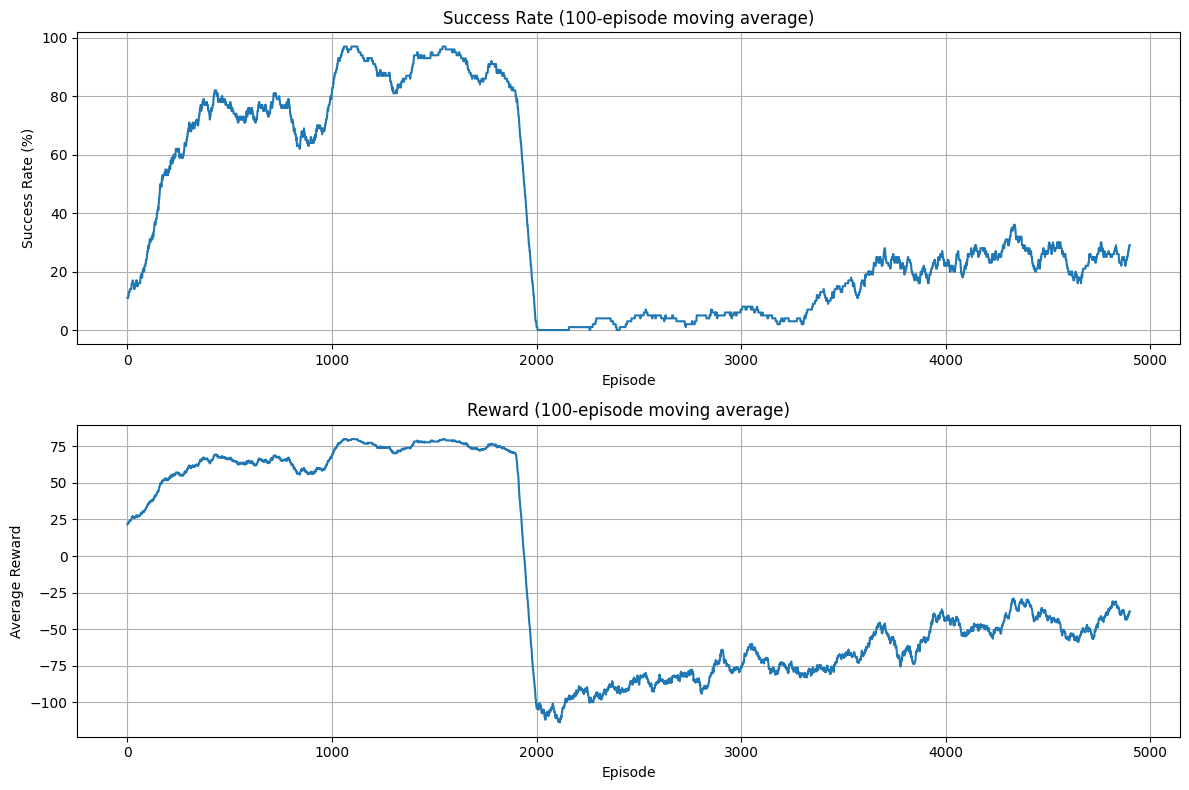


=== Training Complete ===
Phase 1 final success rate: 44.0%
Phase 2 final success rate: 11.0%


In [15]:
print("\n=== PHASE 2: Fine-tuning on DoorKey-6x6-Enemy ===")
env_phase2 = gym.make("MiniGrid-DoorKey-6x6-Enemy-v0")

# Continue training on harder environment - REDUCE epsilon pentru mai puțină explorare
policy_net, rewards2, success2 = train_dueling_dqn(
    env_phase2,
    num_episodes=3000,
    max_steps=200,
    policy_net=policy_net,  # Continue cu modelul din Phase 1
    initial_epsilon=0.9     # Start cu explorare redusă
)

print("\n=== Phase 2 Evaluation ===")
eval_success2, eval_reward2 = evaluate_agent(env_phase2, policy_net, num_episodes=100)
print(f"Success Rate: {eval_success2:.1f}%")
print(f"Average Reward: {eval_reward2:.2f}")

# Save final model
torch.save(policy_net.state_dict(), 'phase2_doorkey_enemy.pth')

# Plot combined results
all_rewards = rewards1 + rewards2
all_success = success1 + success2
plot_results(all_rewards, all_success)

env_phase2.close()

print("\n=== Training Complete ===")
print(f"Phase 1 final success rate: {eval_success1:.1f}%")
print(f"Phase 2 final success rate: {eval_success2:.1f}%")

In [ ]:
# ==========================================================
# 5) Curriculum: Phase 1 (DoorKey) -> Phase 2 (DoorKey+Enemy)
# ==========================================================
env_easy = gym.make("MiniGrid-DoorKey-6x6-v0")  # train without rendering
Q = make_Q(env_easy.action_space.n)

print("\n=== Phase 1: train on MiniGrid-DoorKey-6x6-v0 ===")
rewards1, success1, eps_after = train_q(env_easy, Q,
    episodes=6000, max_steps=500,
    alpha=0.12, gamma=0.99,
    eps_start=1.0, eps_end=0.15, eps_decay=0.99985,
    living_penalty=-0.001, dist_coef=0.040
)



NameError: name 'make_Q' is not defined

In [ ]:
env_hard = gym.make("MiniGrid-DoorKey-6x6-Enemy-v0")  # train without rendering

print("\n=== Phase 2: continue on MiniGrid-DoorKey-6x6-Enemy-v0 ===")
rewards2, success2, _ = train_q(env_hard, Q,
    episodes=8000, max_steps=500,
    alpha=0.06, gamma=0.99,
    eps_start=0.9, eps_end=0.45, eps_decay=0.99996,
    living_penalty=-0.001, dist_coef=0.040
)

print("\nDone.")



=== Phase 2: continue on MiniGrid-DoorKey-6x6-Enemy-v0 ===
Episode 500/8000 | eps=0.882 | avg_reward(last500)=-0.220 | success_rate(last500)=6.60% | TDabs(avg/max)=0.0143/0.5178 | Q(abs/max)=0.346/0.595
Episode 1000/8000 | eps=0.865 | avg_reward(last500)=-0.238 | success_rate(last500)=4.20% | TDabs(avg/max)=0.0289/0.7388 | Q(abs/max)=0.379/0.589
Episode 1500/8000 | eps=0.848 | avg_reward(last500)=-0.202 | success_rate(last500)=7.80% | TDabs(avg/max)=0.6304/0.6304 | Q(abs/max)=0.293/0.423
Episode 2000/8000 | eps=0.831 | avg_reward(last500)=-0.214 | success_rate(last500)=6.80% | TDabs(avg/max)=0.0271/0.5230 | Q(abs/max)=0.266/0.396
Episode 2500/8000 | eps=0.814 | avg_reward(last500)=-0.217 | success_rate(last500)=7.40% | TDabs(avg/max)=0.0105/0.7436 | Q(abs/max)=0.361/0.638
Episode 3000/8000 | eps=0.798 | avg_reward(last500)=-0.190 | success_rate(last500)=9.20% | TDabs(avg/max)=0.0090/0.4488 | Q(abs/max)=0.294/0.476
Episode 3500/8000 | eps=0.782 | avg_reward(last500)=-0.189 | success_ra